## Differential Evolution

In this session, we will discover how Differential Evolution (DE) works. We will explore the underlying principles, implement core components from scratch, apply DE to classic benchmark functions, visualize its dynamics through a generated GIF, and tackle constraints.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from typing import Callable
from dataclasses import dataclass

### Optimization Problems

This cell defines three common benchmark functions, Sphere, Rosenbrock, and Rastrigin, used to test optimization algorithms. We also used these functions earlier to evaluate Adam, Momentum, and CMA-ES.

In [5]:
def sphere(x: np.ndarray) -> float:
    return float(np.sum(x**2))


def rosenbrock(x: np.ndarray) -> float:
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1.0 - x[:-1]) ** 2.0))


def rastrigin(x: np.ndarray) -> float:
    A: float = 10.0
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

BOUNDS = [(-5, 5), (-5, 5)]

### Differential Evolution

Differential Evolution is a simple yet powerful **population-based search algorithm** for continuous optimization. At every iteration it maintains a population of $pop\_size$ candidate solutions, each an $n$-dimensional real-valued vector. Three straightforward operators: mutation, crossover, and selection, are applied to push the population toward regions of lower objective value.

#### 1. Initialisation  
Randomly sample $pop\_size$ vectors inside the problem's bounds.

#### 2. Mutation  
For each target vector $x_i$:

1. Select three distinct solutions $a$, $b$, $c$ (none equal to $x_i$) from current population.  
2. Create the mutant  
   $$v = a + F\,(b - c)$$
   where $F \in (0.4,1^+)$ is the scaling factor. The difference $(b-c)$ supplies direction and scale; $F$ stretches or shrinks the step.

#### 3. Crossover  
Blend the mutant $v$ with its target $x_i$ to form the trial vector \(u\):

- For each coordinate $j$, copy $v_j$ into $u_j$ with probability $CR$; otherwise copy $x_{i,j}$.  
- Force at least one coordinate to come from $v$ so that $u \neq x_i$.

Here $CR \in [0,1]$ is the *crossover rate*: higher $CR$ means aggressive mixing; lower $CR$ leaves the mutant mostly intact.

#### 4. Selection  
Evaluate the objective $f(\cdot)$: $u \text{ replaces } x_i \quad \text{if} \quad f(u) < f(x_i)$

Greedy replacement ensures the population not deteriorates.

#### 5. Iteration & Termination  
After every target has produced a trial and selection is done, the new population is complete. Repeat until a generation limit, a fitness threshold, or a stall criterion is reached.

#### 6. Parameter intuition  

| Parameter | Typical range |
|-----------|---------------|
| Differential weight \(F\) | 0.4 – 1.0 |
| Crossover rate \(CR\)     | 0.1 – 0.9 |
| Population size \(P\)     | $5n$ – $10n$ |

In [6]:
@dataclass
class DEResult:
    best_vector: np.ndarray
    best_value: float
    history: list[np.ndarray] # History of populations for animation


def differential_evolution(
    func: Callable[[np.ndarray], float],
    bounds: list[tuple[float, float]] = BOUNDS,
    pop_size: int = 50,
    F: float = 0.8,
    CR: float = 0.9,
    max_gen: int = 100,
) -> DEResult:
    """
    Implements the Differential Evolution algorithm for global optimization.

    Parameters:
        func: Objective function to minimize. Takes a numpy array and returns a float.
        bounds: list of (min, max) pairs for each dimension.
        pop_size: Number of individuals in the population.
        F: Mutation factor (typically in [0.4, 1.0]).
        CR: Crossover rate (typically in [0, 1]).
        max_gen: Maximum number of generations to evolve.
    """
    dimensions = len(bounds)
    lower_bounds = np.array([b[0] for b in bounds])
    upper_bounds = np.array([b[1] for b in bounds])
    
    # --- Initialization ---
    # Initialize the population: Create pop_size individuals.
    # Each individual is a vector of 'dimensions' length.
    # Use uniform distribution to sample the initial population.
    population = np.random.uniform(
        low=lower_bounds, high=upper_bounds, size=(pop_size, dimensions)
    )
    fitness = np.array([func(ind) for ind in population])
    history = [population.copy()]
    # --- End Initialization ---

    for generation in range(max_gen):
        new_population = np.zeros_like(population)

        for i in range(pop_size):
            # --- Mutation ---
            indices = np.random.choice(
                [idx for idx in range(pop_size) if idx != i], size=3, replace=False
            )
            a, b, c = population[indices]
            mutant_vector = a + F * (b - c)
            mutant_vector = np.clip(mutant_vector, lower_bounds, upper_bounds)
            # --- End Mutation ---

            # --- Crossover ---
            j_rand = np.random.randint(0, dimensions)
            trial_vector = np.array(
                [
                    mutant_vector[j] if np.random.rand() < CR or j == j_rand else population[i][j]
                    for j in range(dimensions)
                ]
            )
            # --- End Crossover ---

            # --- Selection ---
            trial_fitness = func(trial_vector)
            if trial_fitness < fitness[i]:
                new_population[i] = trial_vector
                fitness[i] = trial_fitness
            else:
                new_population[i] = population[i]
            # --- End Selection ---

        population = new_population
        history.append(population.copy())

    best_idx = np.argmin(fitness)
    return DEResult(
        best_vector=population[best_idx],
        best_value=fitness[best_idx],
        history=history,
    )

### Test implemented DE

In [7]:
result = differential_evolution(sphere, bounds=BOUNDS, pop_size=50)

### Visualizing Search Dynamics

In [8]:
def animate_de(
    func: Callable[[np.ndarray], float],
    history: list[np.ndarray],
    bounds: list[tuple[float, float]] = BOUNDS,
    frames: int | None = None,
    filename: str = "de_animation.gif",
) -> None:
    """
    Creates and saves a GIF showing how the DE population moves over generations.
    """
    if frames is None:
        frames = len(history)

    assert len(bounds) == 2, "This function only supports 2D visualization (expected 2 bounds)."
    x_bounds = (bounds[0][0], bounds[0][1])
    y_bounds = (bounds[1][0], bounds[1][1])

    x = np.linspace(x_bounds[0], x_bounds[1], 200)
    y = np.linspace(y_bounds[0], y_bounds[1], 200)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.array([func(pt) for pt in coords]).reshape(X.shape)

    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(X, Y, Z, levels=20, cmap="viridis")
    fig.colorbar(contour, ax=ax)
    
    def init():
        scatter = ax.scatter([], [], s=20, color="red")
        return (scatter,)
    
    def update(i: int):
        ax.set_title(f"Generation {i}")
        pop = history[i]
        scatter = ax.scatter(pop[:, 0], pop[:, 1], s=20, color="red")
        return (scatter,)
    
    ax.set_xlim(x_bounds[0], x_bounds[1])
    ax.set_ylim(y_bounds[0], y_bounds[1])
    
    anim = animation.FuncAnimation(
        fig, update, init_func=init, frames=frames, interval=200, blit=True
    )
    
    writer = animation.PillowWriter(fps=5)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"Animation saved to {filename}")

In [9]:
animate_de(func=sphere, history=result.history)

Animation saved to de_animation.gif


### Experiments
Run DE on all three problems: Sphere, Rosenbrock and Rastrigin. For each problem:
- Generate and analyze convergence plots showing the progression of the best fitness value over iterations.
- Visualize the population dynamics over time to illustrate how the search space is explored and exploited.

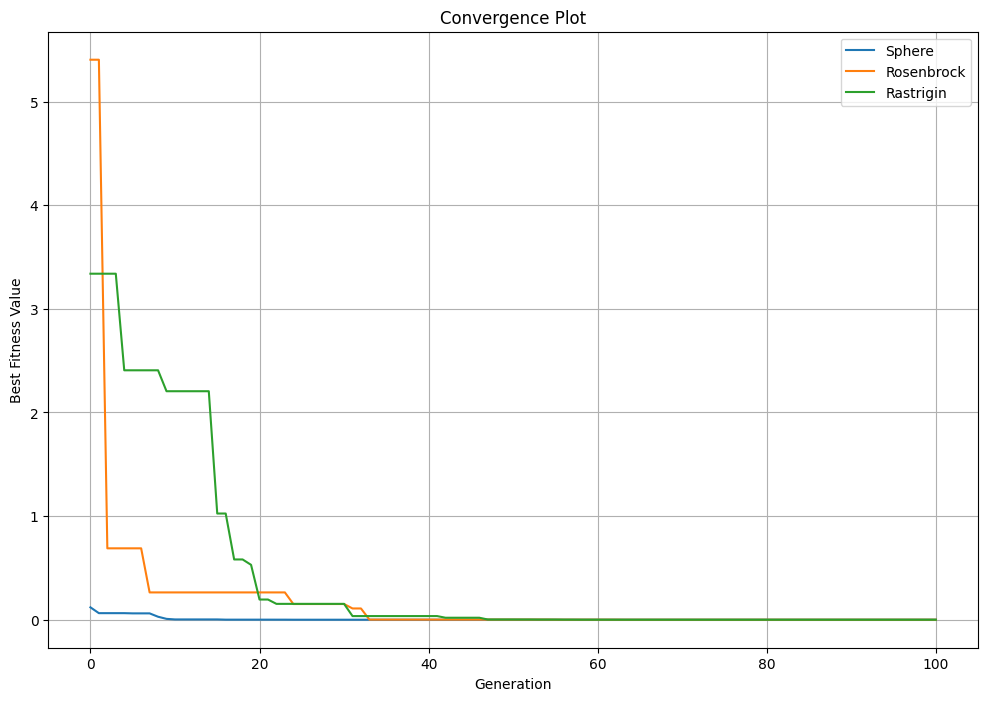

Generating animation for Sphere...
Animation saved to sphere_de_animation.gif
Generating animation for Rosenbrock...
Animation saved to rosenbrock_de_animation.gif
Generating animation for Rastrigin...
Animation saved to rastrigin_de_animation.gif


In [19]:
# Run DE on Sphere, Rosenbrock, and Rastrigin
results = {
    "Sphere": differential_evolution(sphere, bounds=BOUNDS, pop_size=50),
    "Rosenbrock": differential_evolution(rosenbrock, bounds=BOUNDS, pop_size=50),
    "Rastrigin": differential_evolution(rastrigin, bounds=BOUNDS, pop_size=50),
}

# Generate convergence plots
plt.figure(figsize=(12, 8))
for i, (name, result) in enumerate(results.items(), 1):
    best_fitness = [np.min([globals()[name.lower()](ind) for ind in pop]) for pop in result.history]
    plt.plot(best_fitness, label=name)

plt.title("Convergence Plot")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Value")
plt.legend()
plt.grid()
plt.show()

# Visualize population dynamics
for name, result in results.items():
    print(f"Generating animation for {name}...")
    animate_de(func=globals()[name.lower()], history=result.history, filename=f"{name.lower()}_de_animation.gif")

### Hyperparameters in Differential Evolution

Analyze the role and impact of the two key hyperparameters in Differential Evolution: the scaling factor ($F$) and the crossover rate ($CR$).
- What is the primary purpose of each hyperparameter in the context of the DE algorithm?
- How do variations in their values influence the algorithm’s exploration and exploitation behavior?
- Provide examples or illustrations, if possible, to support your analysis.

### Analysis of Hyperparameters in Differential Evolution

#### Scaling Factor ($F$)
- **Purpose**: The scaling factor controls the amplification of the difference vector $(b - c)$ during the mutation step. It determines the magnitude of the step size taken in the search space.
- **Impact**:
    - **Low $F$ (e.g., $F \approx 0.4$)**: Encourages smaller steps, leading to finer exploitation of the search space. This is beneficial when the population is near the global optimum.
    - **High $F$ (e.g., $F > 0.8$)**: Promotes larger steps, enhancing exploration and the ability to escape local optima. However, it may lead to instability or overshooting the optimum.
- **Example**:
    - For the Sphere function, a high $F$ may result in faster convergence initially but could oscillate near the optimum.
    - For the Rastrigin function, a low $F$ may struggle to escape local minima due to the rugged landscape.

#### Crossover Rate ($CR$)
- **Purpose**: The crossover rate determines the probability of mixing components from the mutant vector and the target vector to form the trial vector. It controls the diversity of the population.
- **Impact**:
    - **Low $CR$ (e.g., $CR \approx 0.1$)**: Preserves more of the target vector, leading to slower but more stable convergence. It emphasizes exploitation.
    - **High $CR$ (e.g., $CR \approx 0.9$)**: Encourages aggressive mixing, increasing diversity and exploration. However, it may disrupt convergence if too high.
- **Example**:
    - For the Rosenbrock function, a high $CR$ may help navigate the narrow valley but could slow convergence near the optimum.
    - For the Sphere function, a low $CR$ may lead to slower convergence as the population becomes less diverse.

#### Illustration
To visualize the impact of $F$ and $CR$, we can generate convergence plots for different combinations of these hyperparameters. For example:
- Run DE on the Sphere function with $F = 0.4, 0.8$ and $CR = 0.1, 0.9$.
- Plot the best fitness value over generations to observe the trade-offs between exploration and exploitation.

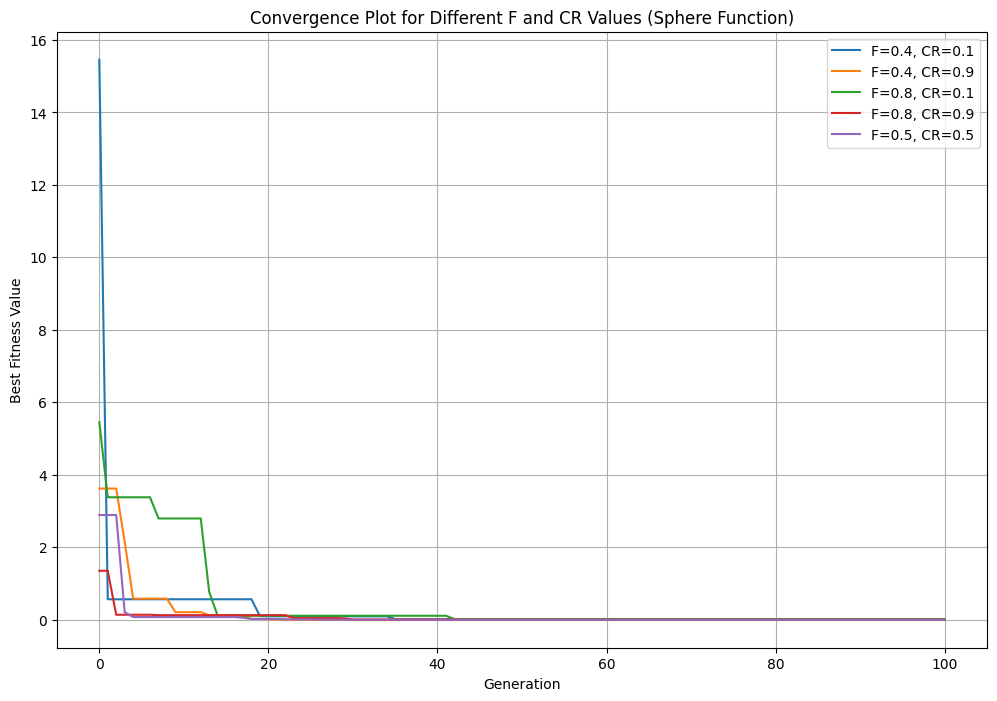

In [ ]:
# Define hyperparameter combinations
hyperparams = [
    {"F": 0.4, "CR": 0.1},
    {"F": 0.4, "CR": 0.9},
    {"F": 0.8, "CR": 0.1},
    {"F": 0.8, "CR": 0.9},
    {"F": 0.5, "CR": 0.5},
]

# Run DE for each combination and store results
convergence_results = {}
for params in hyperparams:
    label = f"F={params['F']}, CR={params['CR']}"
    result = differential_evolution(sphere, bounds=BOUNDS, pop_size=50, F=params["F"], CR=params["CR"])
    best_fitness = [np.min([sphere(ind) for ind in pop]) for pop in result.history]
    convergence_results[label] = best_fitness

# Plot convergence for each combination
plt.figure(figsize=(12, 8))
for label, fitness in convergence_results.items():
    plt.plot(fitness, label=label)

plt.title("Convergence Plot for Different F and CR Values (Sphere Function)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Value")
plt.legend()
plt.grid()
plt.show()

#### Conclusion
The choice of $F$ and $CR$ significantly influences the balance between exploration and exploitation in Differential Evolution. Tuning these hyperparameters is crucial for achieving optimal performance on different optimization problems.

### SHADE: Success-History Based Adaptive Differential Evolution

SHADE is an advanced variant of DE designed to enhance optimization performance through adaptive parameter control. Your task is to critically analyze the research paper [Success-History Based Parameter Adaptation for Differential Evolution](https://metahack.org/CEC2013-SHADE.pdf).
- Summarize the key concepts and mechanisms introduced in SHADE.
- Explain how SHADE differs from the standard DE algorithm.
- Discuss the motivation behind these changes and the empirical improvements demonstrated in the study.

# SHADE Algorithm Summary

## Key Concepts and Mechanisms
SHADE enhances Differential Evolution (DE) with:
- **Historical Memory**: Stores successful $F$ (scaling factor) and $CR$ (crossover rate) values in $M_F$ and $M_{CR}$ (size $H$).
- **Adaptive Parameters**: Generates $F_i$ (Cauchy, $M_{F,k}, 0.1$) and $CR_i$ (Normal, $M_{CR,k}, 0.1$) per individual, clipped to $[0, 1]$.
- **Memory Update**: Updates memory with weighted means of successful $F$ and $CR$, based on fitness improvement.
- **Current-to-pbest/1 Mutation**: $v_i = x_i + F_i \cdot (x_{\text{pbest}} - x_i) + F_i \cdot (x_{r1} - x_{r2}) $, using top $p \cdot NP$ individuals.
- **External Archive**: Stores replaced parents to enhance mutation diversity.

## Differences from Standard DE
- **Parameter Adaptation**: SHADE dynamically adjusts $F$ and $CR$ vs. fixed values in DE.
- **Mutation Strategy**: Uses $\text{current-to-pbest/1}$ vs. $\text{rand/1}$ or $\text{best/1}$.
- **Archive**: Incorporates past solutions, unlike DE’s population-only approach.
- **Memory-Based Learning**: Leverages historical success, absent in DE.

## Motivation
- **Parameter Tuning**: Automates $F$ and $CR$ selection, reducing manual effort.
- **Exploration-Exploitation Balance**: Improves convergence and diversity for complex problems.
- **Robustness**: Adapts to diverse optimization landscapes, unlike static DE.

## Empirical Improvements
- **CEC2013 Benchmarks**: Outperformed DE, JADE, SaDE, and jDE on most functions out of 28.
- **Convergence**: Faster on multimodal and high-dimensional problems.
- **Adaptivity**: Adjusts $CR$ and $F$ to problem types (e.g., high $CR$ for unimodal, low for multimodal).
- **Impact**: SHADE’s successor, L-SHADE, won CEC2014, influencing later competitions.

## Critical Notes
- **Strengths**: Robust, adaptive, and scalable for diverse problems.
- **Limitations**: Sensitive to memory size, modest overhead, and limited real-world testing.
- **Future Work**: Explore alternative distributions and real-world applications.

### Recommended Reading
1. https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
2. Das, Swagatam, and Ponnuthurai Nagaratnam Suganthan. [Differential evolution: A survey of the state-of-the-art.](https://i2pc.es/coss/Docencia/SignalProcessingReviews/Das2011.pdf)
3. Tanabe, Ryoji, and Alex Fukunaga. [Success-history based parameter adaptation for differential evolution.](https://metahack.org/CEC2013-SHADE.pdf)